# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from enum import Enum, IntEnum

In [3]:
import music21

In [4]:
from fastai.text import *
from transformer_xl.default_txl import get_default_model
from enum import Enum
import torch
from fastai.text.models.awd_lstm import *
from fastai.text.models.transformer import *

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
from fastai_data import *

In [7]:
import numpy as np
import torch.nn as nn

In [8]:
from ht_encode import *
import ht_encode

In [9]:
bs=8
bptt=128

In [10]:
import fastai_data
fastai_data.Y_OFFSET=1

In [11]:
path = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/')
# data = LMNPDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/sample')
data = LMNPDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/all')

In [12]:
config = tfmerXL_lm_config

In [13]:
PAD_IDX=enc_config.pad_idx+enc_config.enc_offset

In [14]:
train_ids_file = path/'tmp/all/train_ids.npy'
all_ids = np.load(train_ids_file)
id_cat = np.concatenate(all_ids); id_cat.shape
ax = tuple(range(len(id_cat.shape)-1))
max_vocab = id_cat.max(axis=ax)
max_vocab = (max_vocab+1).tolist(); max_vocab

[15, 13, 5, 15, 15, 15, 15, 5, 7]

In [15]:
N_BAR = 1
N_COMPS = 9
N_EMBS = 128

In [16]:
EMB_IDXS = [0,1,2,3,4,5]
EMB_DIM = [N_EMBS]*len(EMB_IDXS)
VOCAB_SZ = [max_vocab[i] for i in [iN,iNO,iND,iCI] + BIDX_ALL]
EMB_MAP = list(zip(EMB_IDXS,VOCAB_SZ,EMB_DIM))
eN,eO,eD,eI = EMB_MAP
# eN,eO,eD,eI,eB,eM = EMB_MAP

In [17]:
LOSS_WEIGHTS = [1,1,1,0.2,0.2,0.2,0.1,.2,.2]

In [18]:
idx2embidx = {
    iN:eN,iNO:eO,iND:eD,
    iC1:eN,iC2:eN,iC3:eN,iC4:eN,iCD:eD,iCI:eI,
#     iB:eB,
#     iM:eM
}

In [19]:
EMB_MAP

[(0, 15, 128), (1, 13, 128), (2, 5, 128), (3, 7, 128)]

In [20]:
MaskType = Enum('MaskType', 'NoMask Sequential RandomWindow Bert')

In [21]:
config['emb_map'] = EMB_MAP
config['idx_map'] = idx2embidx
config['mask_type'] = MaskType.RandomWindow

In [22]:
total_embs = sum([v[-1] for k,v in idx2embidx.items() if k not in BIDX_ALL])
config['d_model'] = total_embs * N_BAR

In [23]:
config['ctx_len'] = 0
config['mem_len'] = 512
# config['d_inner'] = 1024 * N_BAR
config['d_inner'] = config['d_model'] * 4

In [24]:
config['resid_p'] = 0.3
config['attn_p'] = 0.3
config['ff_p'] = 0.3
config['embed_p'] = 0.3
config['output_p'] = 0.3

In [25]:
config

{'ctx_len': 0,
 'n_layers': 12,
 'n_heads': 10,
 'd_model': 1152,
 'd_head': 41,
 'd_inner': 4608,
 'resid_p': 0.3,
 'attn_p': 0.3,
 'ff_p': 0.3,
 'embed_p': 0.3,
 'output_p': 0.3,
 'bias': False,
 'scale': True,
 'act': <Activation.ReLU: 1>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 15, 128), (1, 13, 128), (2, 5, 128), (3, 7, 128)],
 'idx_map': {0: (0, 15, 128),
  1: (1, 13, 128),
  2: (2, 5, 128),
  3: (0, 15, 128),
  4: (0, 15, 128),
  5: (0, 15, 128),
  6: (0, 15, 128),
  7: (2, 5, 128),
  8: (3, 7, 128)},
 'mask_type': <MaskType.RandomWindow: 3>}

In [26]:
# # BERT config
# config['mask_type'] = MaskType.Bert
# config['mem_len'] = 0
# config['d_model'] = N_EMBS

In [27]:
class TransformerEmbed(nn.Module):
    def __init__(self, emb_map, idx_map, embed_p:float=0.1, **kwargs):
        super().__init__()
        # note, octave, duration, instrument
        self.idx_map = idx_map
        self.emb_map = emb_map
        embeddings = []
        for idx,in_d,out_d in emb_map:
            embeddings.append(nn.Embedding(in_d, out_d, padding_idx=PAD_IDX))
        self.embeddings = nn.ModuleList(embeddings)
        self.drop_emb = nn.Dropout(embed_p)
        
    def forward(self, x):
        # batch x bptt x (n,o,d,i)
        if BIDX_ALL: pos_enc = self.embeddings[eB[0]](x[...,iB]) + self.embeddings[eM[0]](x[...,iM])
        embs = []
        for i in range(x.shape[-1]):
            emb_idx = self.idx_map[i][0]
            if i in BIDX_ALL: continue
            embx = self.embeddings[emb_idx](x[...,i])
            if BIDX_ALL: embx.add_(pos_enc)
            embs.append(embx)
        emb = torch.stack(embs, dim=-2) # barlen x comp x emb
#         emb = emb.permute(0,1,4,2,3) # for conv - emb x barlen x comp
        return self.drop_emb(emb)

In [28]:
class TXLLinearDecoder(nn.Module):
    "To go on top of a RNNCore module and create a Language Model."
    initrange=0.1

    def __init__(self, tie_encoder:nn.Module=None, bias:bool=True, input_dim=None):
        super().__init__()
        n_hid,n_out = tie_encoder.embedding_dim, tie_encoder.num_embeddings
        self.decoder = nn.Linear(n_hid, n_out, bias=bias)
        self.decoder.weight.data.uniform_(-self.initrange, self.initrange)
        if bias: self.decoder.bias.data.zero_()
        if tie_encoder: self.decoder.weight = tie_encoder.weight
            
        if input_dim is not None and input_dim != n_hid:
            self.decoder = nn.Sequential(nn.Linear(input_dim, n_hid), self.decoder)

    def forward(self, input):
        return self.decoder(input)

In [29]:
class TransformerDec(nn.Module):
    def __init__(self, txl_emb, idx_map, output_p=0.0, out_bias=True, d_model=None, **kwargs):
        super().__init__()
        self.output_dp = RNNDropout(output_p)
        
        decoders = []
        for k,v in idx_map.items():
            if k in BIDX_ALL: continue
            emb = txl_emb.embeddings[v[0]]
            decoder = TXLLinearDecoder(tie_encoder=emb, bias=out_bias, input_dim=d_model)
            decoders.append(decoder)
            
        self.decoders = nn.ModuleList(decoders)
        
    def forward(self, input):
        raw_outputs, outputs = input
        output = self.output_dp(outputs[-1])
#         dim_shape = [N_BAR, N_COMPS, N_EMBS] if N_BAR > 1 else [N_COMPS, N_EMBS]
#         output = output.view(*output.shape[:-1], *dim_shape)
#         output = output.view(output.shape[0], -1, *dim_shape)
        res = []
        for idx,dec in enumerate(self.decoders):
            res.append(dec(output))
        return res, raw_outputs, outputs

In [30]:
def rand_window_mask(x_len,m_len,device):
    win_size,k = (np.random.randint(0,16)+1,0) if m_len > 0 else (1,1)
    mem_mask = np.zeros((x_len,m_len))
    tri_mask = np.triu(np.ones((x_len//win_size+1,x_len//win_size+1)),k=k)
    window_mask = tri_mask.repeat(win_size,axis=0).repeat(win_size,axis=1)[:x_len,:x_len]
    np_mask = np.concatenate((mem_mask, window_mask), axis=1)
    mask = torch.tensor(np_mask, device=device).byte()[None,None]; mask
    return mask

In [31]:
def bert_mask(x_len,m_len,device):
    # create mask where only melody is hidden
    # reshape input and remove 9 cats
    rand = torch.rand(x_len,x_len)
    mem_mask = torch.zeros(x_len,m_len).byte()
    mask = rand < 2
    comp = len(idx2embidx)
    rand = torch.rand(x_len,x_len)
    mem_mask = torch.zeros(x_len,m_len).byte()
    mask = rand < 0.8
#     mask = mask.view(bptt,comp,bptt,comp)
#     mask[:,CIDX_ALL] = 0
#     mask[...,CIDX_ALL] = 0
#     mask = mask.view(x_len,x_len)
    mask = torch.cat((mem_mask, mask), dim=-1)
    return mask.byte().to(device)[None,None]
    

In [32]:

class LMNPTransformerXL(nn.Module):
    "TransformerXL model: https://arxiv.org/abs/1901.02860."
    def __init__(self, encoder, ctx_len:int, n_layers:int, n_heads:int, d_model:int, d_head:int, d_inner:int, 
                 resid_p:float=0., attn_p:float=0., ff_p:float=0., embed_p:float=0., bias:bool=False, scale:bool=True,
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls:Callable=MultiHeadRelativeAttention,
                 learned_pos_enc:bool=False, mask_type:MaskType=MaskType.Sequential, mem_len:int=0, **kwargs):
        super().__init__()
        self.encoder = encoder
        self.pos_enc = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.u = nn.Parameter(torch.Tensor(n_heads, 1, d_head)) #Remove 1 for einsum implementation of attention
        self.v = nn.Parameter(torch.Tensor(n_heads, 1, d_head)) #Remove 1 for einsum implementation of attention
        self.mem_len,self.n_layers,self.d_model,self.mask_type = mem_len,n_layers,d_model,mask_type
        self.init = False
        self.layers = nn.ModuleList([DecoderLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                      ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop, 
                      attn_cls=attn_cls) for k in range(n_layers)])
    
    def reset(self):
        "Reset the internal memory."
        self.hidden = [next(self.parameters()).data.new(0) for i in range(self.n_layers+1)]

    def _update_mems(self, hids):
        if not getattr(self, 'hidden', False): return None
        assert len(hids) == len(self.hidden), 'len(hids) != len(self.hidden)'
        with torch.no_grad():
            for i in range(len(hids)):
                cat = torch.cat([self.hidden[i], hids[i]], dim=1)
                self.hidden[i] = cat[:,-self.mem_len:].detach()
    
    def select_hidden(self, idxs): self.hidden = [h[idxs] for h in self.hidden]
    
    def forward(self, x):
        #The hidden state has to be initiliazed in the forward pass for nn.DataParallel
        if self.mem_len > 0 and not self.init: 
            self.reset()
            self.init = True
        inp = self.encoder(x)
        if self.mask_type.value == MaskType.Bert.value:
            inp = inp.reshape(inp.shape[0], -1, inp.shape[-1]) # bs,bptt,comp,emb -> bs,bptt*comp,emb
        else:
            inp = inp.reshape(*inp.shape[:2], -1) # bs,bptt,comp,emb -> bs,bptt,comp,emb
        bs,x_len = inp.shape[:2]
        m_len = self.hidden[0].size(1) if hasattr(self, 'hidden') and len(self.hidden[0].size()) > 1 else 0
        seq_len = m_len + x_len
        
        if self.mask_type.value == MaskType.NoMask.value: 
            self.mask = None
        elif self.mask_type.value == MaskType.RandomWindow.value: 
            self.mask = rand_window_mask(x_len,m_len,x.device)
        elif self.mask_type.value == MaskType.Sequential.value: 
            self.mask = torch.triu(x.new_ones(x_len, seq_len), diagonal=1+m_len).byte()[None,None]
        elif self.mask_type.value == MaskType.Bert.value: 
            self.mask = bert_mask(x_len,m_len,x.device)
        else: 
            raise ValueError('Unhandled mask type:', self.mask_type)
        #[None,:,:None] for einsum implementation of attention
        hids = []
        pos = torch.arange(seq_len-1, -1, -1, device=inp.device, dtype=inp.dtype)
        pos_enc = self.pos_enc(pos)
        hids.append(inp)
        for i, layer in enumerate(self.layers):
            mem = self.hidden[i] if self.mem_len > 0 else None
            inp = layer(inp, r=pos_enc, u=self.u, v=self.v, mask=self.mask, mem=mem)
            hids.append(inp)
        core_out = inp[:,-x_len:]
        if self.mem_len > 0 : self._update_mems(hids)
        return (self.hidden if self.mem_len > 0 else [core_out]),[core_out]

In [33]:
def get_language_model(config:dict=None, drop_mult:float=1.):
    "Create a language model from `arch` and its `config`, maybe `pretrained`."
    for k in config.keys(): 
        if k.endswith('_p'): config[k] *= drop_mult
    init = config.pop('init') if 'init' in config else None
    
    embed = TransformerEmbed(**config)
    txl = LMNPTransformerXL(embed, **config)
    decoder = TransformerDec(embed, **config)
    model = SequentialRNN(txl, decoder)
    
    return model if init is None else model.apply(init)


def language_model_learner(data:DataBunch, config:dict=None, drop_mult:float=1., pretrained:bool=True,
                           **learn_kwargs) -> 'LanguageLearner':
    "Create a `Learner` with a language model from `data` and `arch`."
    model = get_language_model(config=config, drop_mult=drop_mult)
    learn = LanguageLearner(data, model, split_func=tfmer_lm_split, **learn_kwargs)
    return learn

In [34]:
class LMNPLoss(nn.Module):
    "Same as `func`, but flattens input and target."
    def __init__(self, model):
        super().__init__()
        self.fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX) 
        self.model = model
        # not using func otherwise _loss_func_name2activ uses this attribute to get cross entropy loss

    def __repr__(self): return f"numpyenc loss of {self.fn}"

    def forward(self, inputs:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        losses = []
        
#         target = target.clone()
#         mask = self.model[0].mask
#         ts_mask = mask[...,torch.eye(mask.shape[-1]).byte()]
#         ts_mask = ts_mask.view(target.shape[1:])
#         target[..., ~ts_mask] = PAD_IDX
        
        for idx,input in enumerate(inputs):
#             if idx in CIDX_ALL: continue
            t = target[...,idx]
            input = input.view(-1,input.shape[-1])
            losses.append(self.fn(input, t.view(-1))*LOSS_WEIGHTS[idx])
        return sum(losses)

In [35]:
import pdb

In [36]:
def lmnp_accuracy(inputs:Tensor, target:Tensor, model)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
#     target = target.clone()
#     mask = model[0].mask
#     ts_mask = mask[...,torch.eye(mask.shape[-1]).byte()]
#     ts_mask = ts_mask.view(target.shape[1:])
#     target[..., ~ts_mask] = PAD_IDX
    
    inputs = [i.argmax(dim=-1).unsqueeze(dim=-1) for i in inputs]
    input_cat = torch.cat(inputs, dim=-1)
    target = target.view(input_cat.shape)
    
        
    input_cat,target = input_cat.cpu().numpy(), target.cpu().numpy()
    acc = (input_cat==target).astype(float)
    acc[target==PAD_IDX] = np.nan
#     acc[...,CIDX_ALL] = np.nan
#     pdb.set_trace()
    return torch.tensor(np.nanmean(acc))

In [37]:
learn = language_model_learner(data, config, clip=0.25)

In [38]:
learn.loss_func = LMNPLoss(learn.model)

In [39]:
acc_met = partial(lmnp_accuracy, model=learn.model)

In [40]:
learn.metrics = [acc_met]

In [39]:
ob = data.one_batch(cpu=False)
out = learn.pred_batch(ob)
learn.loss_func([c.cuda() for c in out], ob[1])

tensor(9.5672, device='cuda:0')

In [40]:
# # # clip = 0.5
# learn.lr_find(num_it=300)
# learn.recorder.plot()

In [41]:
learn.fit_one_cycle(5, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,1.614666,1.623789,0.913959,14:53
1,1.354705,1.479076,0.921742,14:52
2,1.304004,1.317892,0.929933,14:51
3,1.192497,1.238115,0.935375,14:49
4,1.231383,1.199790,0.936709,14:46


In [42]:
learn.validate()

[1.2043456, tensor(0.9368)]

In [43]:
learn.save('first_run_10ep')

In [46]:
learn.fit_one_cycle(5, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,1.337372,1.288798,0.932526,14:50
1,1.382319,1.416606,0.927723,14:51
2,1.282228,1.287018,0.932393,14:55
3,1.221084,1.222616,0.935772,14:53
4,1.270180,1.200249,0.937181,14:54


In [47]:
learn.save('second_run_5ep')

In [41]:
learn.load('second_run_5ep');

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type TransformerEmbed. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type TransformerDec. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type TXLLinearDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type LMNPLoss. It won't be chec

In [43]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,1.420191,1.340243,0.933633,10:19
1,1.433485,1.344226,0.933513,10:16
2,1.364644,1.301896,0.934686,10:17
3,1.322006,1.262710,0.935965,10:17
4,1.319828,1.283599,0.935785,10:17


In [44]:
learn.save('third_run_5ep')

In [45]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,1.268372,1.287055,0.936026,10:18
1,1.363380,1.265400,0.935555,10:18
2,1.346844,1.286509,0.935161,10:18
3,1.287819,1.266491,0.936516,10:18
4,1.321752,1.286389,0.935656,10:18
5,1.293938,1.267191,0.936322,10:18
6,1.253542,1.274321,0.936710,10:18
7,1.241654,1.250910,0.937086,10:18
8,1.200968,1.261549,0.937007,10:17
9,1.215747,1.252857,0.937317,10:19


In [46]:
from fastai import basic_train

In [47]:
def predict_func(parts): return [F.softmax(p, dim=-1) for p in parts]

In [48]:
loss_func_name = camel2snake(learn.loss_func.__class__.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func
basic_train._loss_func2activ(learn.loss_func)

<function __main__.predict_func(parts)>

In [49]:
bos_idx = enc_config.enc_offset+enc_config.bos_idx

def get_positions(xb):
    beat_enc = xb[...,-1,:,iB]
    enc_offset = enc_config.enc_offset
    measure_enc = ((xb[...,-1,:,iM]-enc_offset+1)%8)+enc_offset
    if (xb[:,-1]==enc_offset+enc_config.bos_idx).any(): 
#         print('Last timestep was BOS token. Currently unable to handle that. Returning')
        raise Exception('Last timestep was BOS token. Currently unable to handle that')
    return [beat_enc.squeeze(),measure_enc.squeeze()]

def predict(self, xb, n_words:int=1, temperature:float=1., min_p:float=None):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    learn.model[0].mask = False
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy()
    yb = torch.ones_like(xb)
    timesteps = []
    for _ in progress_bar(range(n_words), leave=True):
        bar = get_positions(xb) if BIDX_ALL else []
        outputs = learn.pred_batch(batch=(xb,yb))
        for item in outputs: #progress_bar(range(n_words), leave=False):
            res = item[0][-1]
            if min_p is not None: 
                if (res >= min_p).float().sum() == 0:
                    warn(f"There is no item with probability >= {min_p}, try a lower value.")
                else: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1)
#             val,idx = torch.topk(res, 1)
            bar.append(idx.squeeze().to(xb.device))
        bar = torch.stack(bar, dim=-1)
        if (bar==bos_idx).any(): 
            print('Predicted BOS token. Returning prediction...')
            break
        timesteps.append(bar.cpu().numpy())
        xb = bar.clone().detach()[None,None] # don't use timesteps. use it's own memory instead
    
    learn.model[0].mask = True
    return timesteps, seed.squeeze()


### From batch

In [50]:
xb,yb = learn.data.one_batch(cpu=False)

### From song

In [51]:
seed_len = 60
files = get_files(path/'hooktheory', extensions=['.npy'], recurse=True)

In [52]:
# Loading from specific file
keywords = ['third', 'eye']
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/z/zun/satori-maiden---third-eye/chorus.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/z/zun/satori-maiden---third-eye/verse-and-pre-chorus.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/jumper/chorus.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/never-let-you-go/chorus.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/never-let-you-go/verse-and-pre-chorus.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/hows-it-going-to-be/intro.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/hows-it-going-to-be/verse.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy'),
 PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos

In [85]:
file = np.random.choice(files)
# file = search[-2]
file

PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/the-lively-ones/surf-rider/chorus.npy')

In [86]:
# good_one = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
# la_bamba = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/r/ritchie-valen/la-bamba/chorus.npy')
# third_eye = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')
# surf = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/the-lively-ones/surf-rider/chorus.npy')






In [110]:
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(seed_np).cuda()[None]

### Predict

In [101]:
out, seed = predict(learn, xb, n_words=340, temperature=.7, min_p=0.01)

Predicted BOS token. Returning prediction...


### Actual prediction

In [102]:
song = dec_arr(np.array(out)); song

Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit
Broken encoding. Sustained chord with out a hit


Part[0]:
[Chords]:
[[6, 1, 3, 3]])
[[4, 6, 1, 3]])
[[3, 5#, 7, 2]])
[[6, 1, 3, 5]])
[[3, 5#, 7, 2]])

[Notes]:
2
2
2
3
3
6
7
1
3
6
7
1
7
6
5
4
6
7
1
4
6
7
1
7
6
5
3
3
5#
7
3
3
2
7
5#
3
3
2
3
2
2
2
2
3



HMetadata(title='decoded', BPM='120', beats_in_measure='4', key='C', mode='1')

In [103]:
stream = song.to_stream()

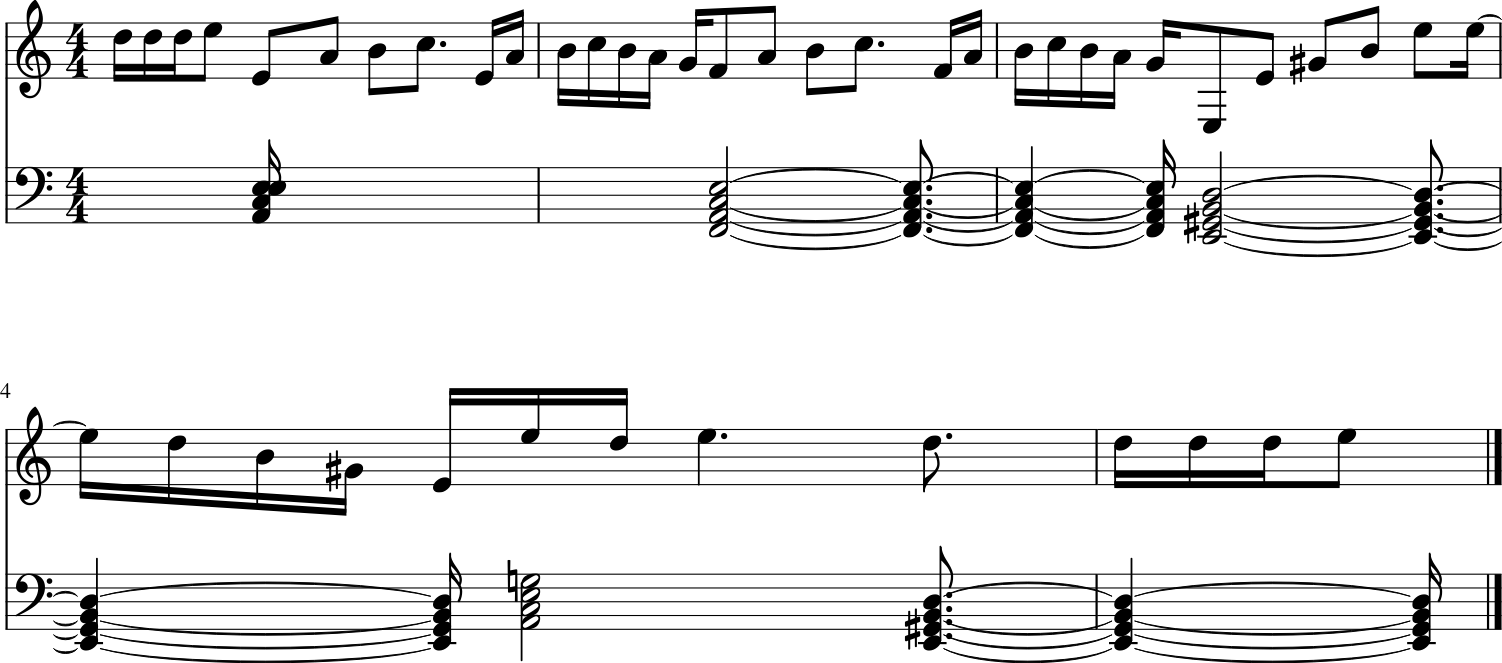

In [104]:
stream.show()

In [105]:
stream.show('midi')

## Seed

In [111]:
seed_song = dec_arr(seed)
seed_stream = seed_song.to_stream()

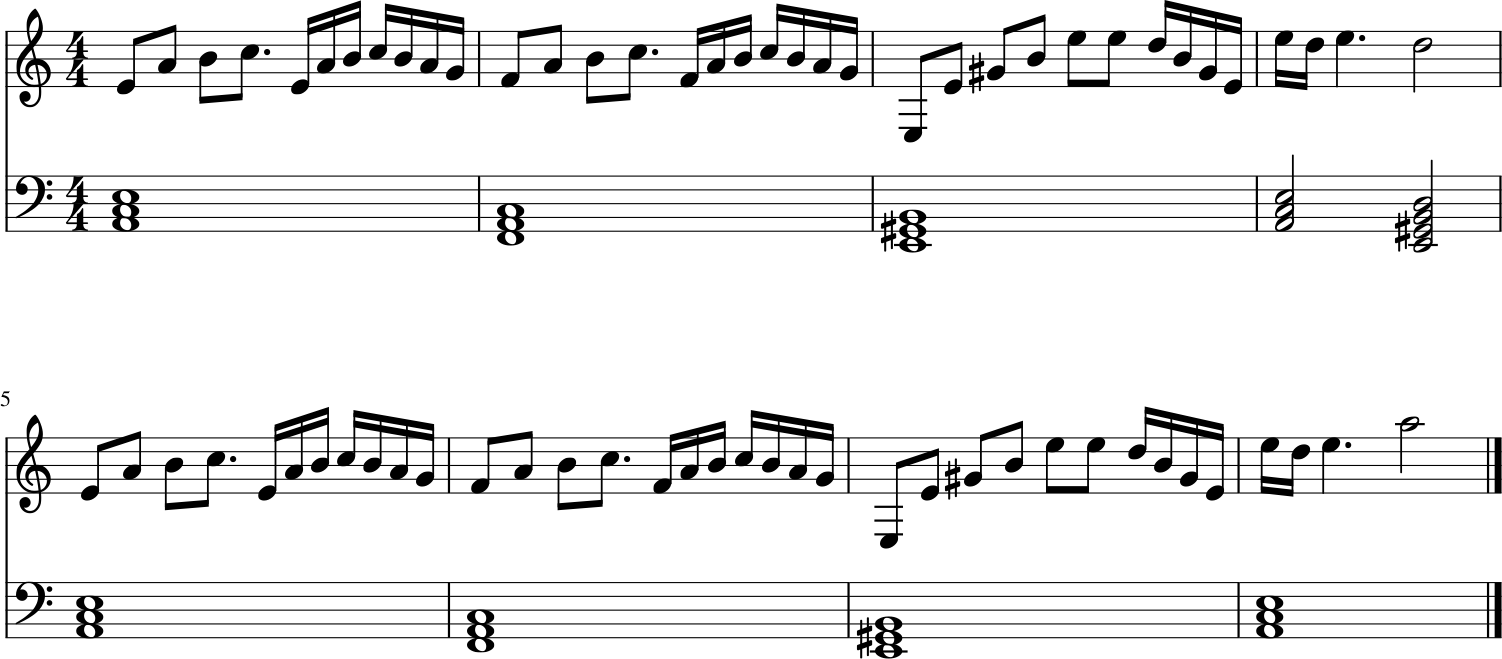

In [112]:
seed_stream.show()

In [113]:
seed_stream.show('midi')